# Hypervector Capacity

These are experiments exploring the capabilities of hypervectors. 



## Storing values in hypervectors

Many machine learning algorithms require statistical analysis of input streams, but tokens...

Here, comparing values stored in hypervectors to true values. 

In [1]:
import random_idx
import utils
import pickle
import time
import string
from pylab import *
%matplotlib inline

height has been deprecated.

2016-04-18 11:17


In [2]:
fdict = open("raw_texts/texts_english/alice_in_wonderland.txt")
alice_text = fdict.read().lower()
punct = string.punctuation + string.digits

for i in punct:
    if i == '-':
        alice_text = alice_text.replace(i, ' ')
    else:
        alice_text = alice_text.replace(i, '')
    
alice_text = alice_text.replace('\n', ' ')
alice_text = alice_text.replace('\r','')
alice_text = alice_text.replace('\t','')
alice_text = alice_text[504:137330] # taking out the header/footer text

### Storing information about letter statistics in hypervectors



In [3]:
N = 10000
letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1
letters = random_idx.alphabet.replace(' ', '_')

In [4]:
alice_vector1 = np.zeros(N)
for l in alice_text:
    alice_vector1 += letter_vectors[random_idx.alphabet.find(l), :]
alice_vector1 = alice_vector1 / len(alice_text)
hyp_prob1 = np.dot(letter_vectors, alice_vector1.T) / N

In [5]:
letter_counts = np.zeros(len(random_idx.alphabet))

for i,letter in enumerate(random_idx.alphabet):
    letter_counts[i] = alice_text.count(letter)

letter_prob = letter_counts / sum(letter_counts)

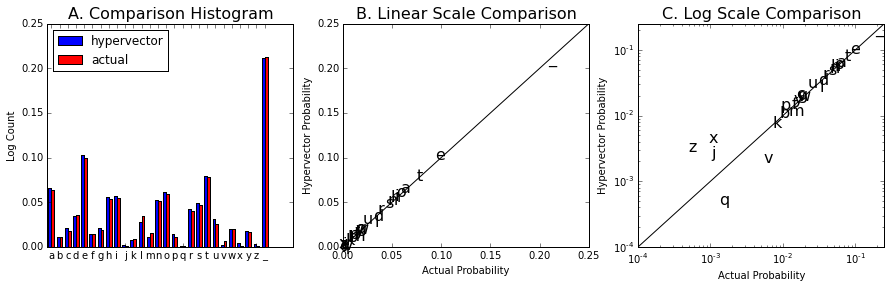

In [6]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hyp_prob1))+0.15, abs(hyp_prob1), width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, letter_prob, width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hyp_prob1))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Log Count')
ax1.set_title('A. Comparison Histogram', fontsize=16)

ax2 = subplot(132)
plot([0, 1], [0, 1], 'k')

ax3 = subplot(133)
plot([0, 1], [0, 1], 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(letter_prob[i], abs(hyp_prob1[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(letter_prob[i], abs(hyp_prob1[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim([0, 0.25])
ax2.set_ylim([0, 0.25])

ax2.set_xlabel('Actual Probability')
ax2.set_ylabel('Hypervector Probability')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim([1e-4, 0.25])
ax3.set_xscale('log')
ax3.set_ylim([1e-4, 0.25])
ax3.set_yscale('log')

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

**Figure 1. Statistics of unigrams in alice and wonderland text:** A. Histograms of unigram probabilities stored in the hypervector compared with the actual probability in the text. The small amount of noise in the hypervector is due to the expected small dot product of nearly orthogonal representations. B. Scatter plot comparison of letter probabilities and values stored in the hypervector. C. Log scale of scatter plot comparion. Very low-probability values are proportionally more noisy.


### Storing the log values

There could be several advantages to storing the log values of the counts in hypervectors. This could reduce the amount of proportional noise for low-likelihood values. Further, storing the log likelihoods could be useful for quickly computing the products of probabilities.

In order to store the log counts in the hypervector, we weight the letter_vectors based on the number of occurences that are already stored in the hypervector.


In [7]:
alice_vector_log = np.zeros(N)
letter_val = np.zeros(len(alice_text))
for il,l in enumerate(alice_text):
    # Read out the log count of the letter value
    letter_val[il] = np.dot(letter_vectors[random_idx.alphabet.find(l),:], alice_vector_log.T) / N
    # Only increment the hypervector value for this letter based on its count
    alice_vector_log += 1.0 / (np.exp(letter_val[il])) * letter_vectors[random_idx.alphabet.find(l),:]

alice_vector_log = alice_vector_log
hyp_prob_log = np.dot(letter_vectors, alice_vector_log.T) / N

This process should then store the log values of each letter over time, we can compare this to the expected log plot as we encounter each letter going through the text.

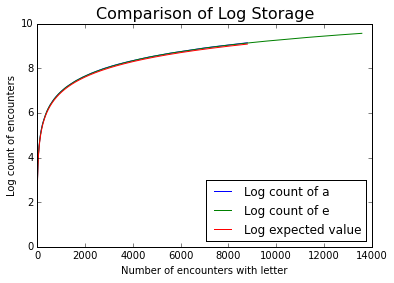

In [8]:
import re
idxs1 = np.array([match.start() for match in re.finditer('a', alice_text)])
idxs2 = np.array([match.start() for match in re.finditer('e', alice_text)])

plot(letter_val[idxs1], label='Log count of a')
plot(letter_val[idxs2], label='Log count of e')
plot(np.log(arange(len(idxs1))+1), label='Log expected value')
legend(loc='lower right')
xlabel('Number of encounters with letter')
ylabel('Log count of encounters')
title('Comparison of Log Storage', fontsize=16)


**Figure 2. Readout and weighted storage to encode log counts on the fly.** The log counts of each letter was stored by accumulating the letter vectors proportionally to their current log counts stored in the hypervector. Weighting the letter vectors accurately stored the log values as each letter was encountered during the encoding.



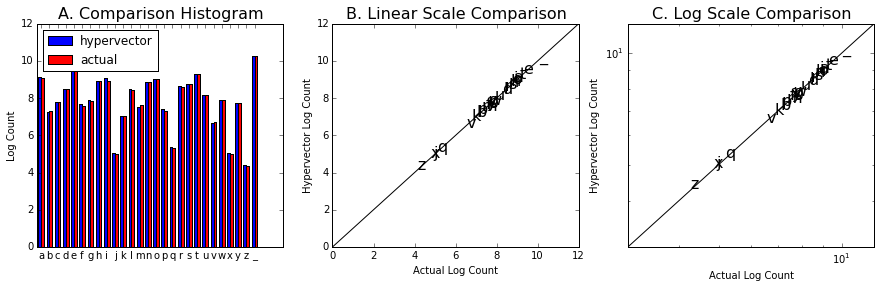

In [9]:
figure(figsize=(15,4))

ax1 = subplot(131)

bar(arange(len(hyp_prob_log))+0.15, hyp_prob_log, width=0.35, color='b', label='hypervector')
bar(arange(len(letter_prob))+0.5, np.log(letter_counts), width=0.35, color='r', label='actual')

ax1.set_xticks(arange(len(hyp_prob1))+0.5)
th = ax1.set_xticklabels(list(letters))

ax1.legend(loc='upper left')
ax1.set_ylabel('Log Count')
ax1.set_title('A. Comparison Histogram', fontsize=16)

ax2 = subplot(132)
plot([1e-3, 12], [1e-3, 12], 'k')

ax3 = subplot(133)
plot([1e-3, 12], [1e-3, 12], 'k')

for i,l in enumerate(letters):
    if letter_prob[i] < 1e-7:
        continue
        
    # abs to deal with potential negatives
    ax2.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')
    
    ax3.text(np.log(letter_counts[i]), abs(hyp_prob_log[i]), 
         l, fontsize=16, ha='center', va='center')

ax2.set_xlim([0, 12])
ax2.set_ylim([0, 12])

ax2.set_xlabel('Actual Log Count')
ax2.set_ylabel('Hypervector Log Count')
ax2.set_title('B. Linear Scale Comparison', fontsize=16)

ax3.set_xlim([3e0, 12])
ax3.set_xscale('log')
ax3.set_ylim([3e0, 12])
ax3.set_yscale('log')

ax3.set_xlabel('Actual Log Count')
ax3.set_ylabel('Hypervector Log Count')
ax3.set_title('C. Log Scale Comparison', fontsize=16)

**Figure 3. Log statistics of unigrams in alice and wonderland text:** A. Histograms of unigram log counts stored in the hypervector compared with the actual log counts in the text. B. Scatter plot comparison of letter probabilities and values stored in the hypervector. C. Log scale of scatter plot comparion. Very low-probability values are not as proportionally noisy.


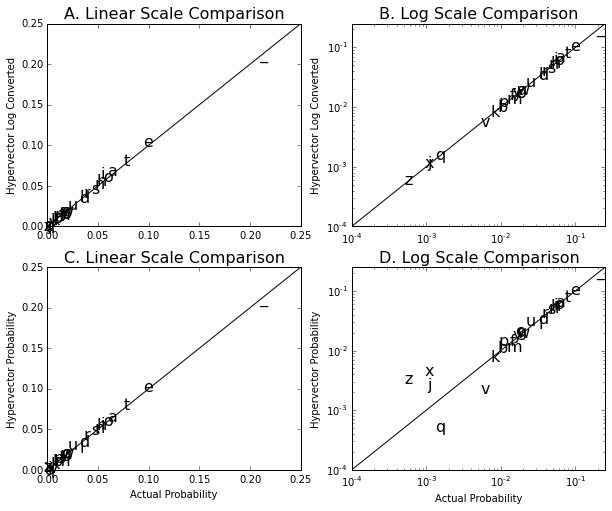

In [10]:
figure(figsize=(10, 8))

ax1=subplot(221)
ax1.plot([1e-5, 3e-1], [1e-5, 3e-1], 'k')
ax2=subplot(222)
ax2.plot([1e-5, 3e-1], [1e-5, 3e-1], 'k')
ax3=subplot(223)
ax3.plot([1e-5, 3e-1], [1e-5, 3e-1], 'k')
ax4=subplot(224)
ax4.plot([1e-5, 3e-1], [1e-5, 3e-1], 'k')

for i,ll in enumerate(letters):
    if letter_counts[i] < 1:
        continue
    
    ax1.text(letter_counts[i]/len(alice_text)+1e-5, np.exp(abs(hyp_prob_log[i]))/len(alice_text),
         ll, fontsize=16, ha='center', va='center')    
    ax3.text(letter_counts[i]/len(alice_text)+1e-5, abs(hyp_prob1[i])+1e-5,
         ll, fontsize=16, ha='center', va='center')
    
    ax2.text(letter_counts[i]/len(alice_text)+1e-5, np.exp(abs(hyp_prob_log[i]))/len(alice_text), 
         ll, fontsize=16, ha='center', va='center')
    ax4.text(letter_counts[i]/len(alice_text)+1e-5, abs(hyp_prob1[i])+1e-5,
         ll, fontsize=16, ha='center', va='center')

ax1.set_xlim([0, 0.25])
ax1.set_ylim([0, 0.25])

ax1.set_ylabel('Hypervector Log Converted')
ax1.set_title('A. Linear Scale Comparison', fontsize=16)

ax3.set_xlim([0, 0.25])
ax3.set_ylim([0, 0.25])

ax3.set_xlabel('Actual Probability')
ax3.set_ylabel('Hypervector Probability')
ax3.set_title('C. Linear Scale Comparison', fontsize=16)

ax2.set_xlim([1e-4, 0.25])
ax2.set_xscale('log')
ax2.set_ylim([1e-4, 0.25])
ax2.set_yscale('log')

ax2.set_ylabel('Hypervector Log Converted')
ax2.set_title('B. Log Scale Comparison', fontsize=16)

ax4.set_xlim([1e-4, 0.25])
ax4.set_xscale('log')
ax4.set_ylim([1e-4, 0.25])
ax4.set_yscale('log')

ax4.set_xlabel('Actual Probability')
ax4.set_ylabel('Hypervector Probability')
ax4.set_title('D. Log Scale Comparison', fontsize=16)

** Figure 4. Comparison of direct versus log storage:** A and B. Scatter plot of reconstructed probabilities from storage of log counts, shown on linear (A) and log (B) scales. C and D. Scatter plot of directly stored probabilities (same as Fig 1. B and C).

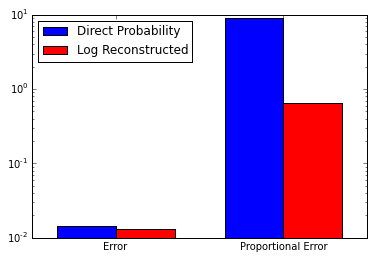

In [11]:
prob_error = (sum((letter_prob - abs(hyp_prob1))**2))**0.5
prob_log_error = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))**2))**0.5

prob_perror = (sum((letter_prob - abs(hyp_prob1))/letter_prob)**2)**0.5
prob_log_perror = (sum((letter_prob - np.exp(abs(hyp_prob_log))/len(alice_text))/letter_prob)**2)**0.5

bar(np.array([0, 1]) + 0.15, np.array([prob_error, prob_perror]), 
    width=0.35, label='Direct Probability', color='b')
bar(np.array([0, 1]) + 0.5, np.array([prob_log_error, prob_log_perror]), 
    width=0.35, label='Log Reconstructed', color='r')

ax = gca()
ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_xticks([0.5, 1.5])
ax.set_xticklabels(['Error', 'Proportional Error'])

### Storing bigrams in hypervectors

In [12]:
ngram = 2
ngram_vector = np.ones(N)
alice_vector2 = np.zeros(N)

for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)

    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    alice_vector2 += ngram_vector
    
    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])

    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))
    
    
alice_vector2 = alice_vector2 / len(alice_text)


The bigram hypervector does not contain any information about the unigram statistics (because we did not store this information). 


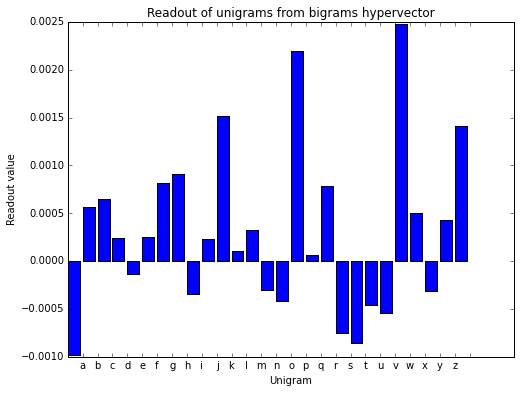

In [13]:
hyp_prob2 = np.dot(letter_vectors, alice_vector2.T) / N
figure(figsize=(8,6));

bar(arange(len(hyp_prob2)), hyp_prob2)

ax = gca()

ax.set_xticks(arange(len(random_idx.alphabet))+1)
th = ax.set_xticklabels(list(random_idx.alphabet))

title('Readout of unigrams from bigrams hypervector')
xlabel('Unigram');
ylabel('Readout value')

In [14]:
letter_vals2 = np.zeros(len(random_idx.alphabet)**2)
letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
letter_pairs = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        
        letter_pairs.append(letter1+letter2)
        
        letter_counts2[c] = alice_text.count(letter_pairs[c])
        
        vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]
        
        letter_vals2[c] = np.dot(vector, alice_vector2.T) / N
        c+=1

#%%
letter_prob2 = letter_counts2 / sum(letter_counts2)


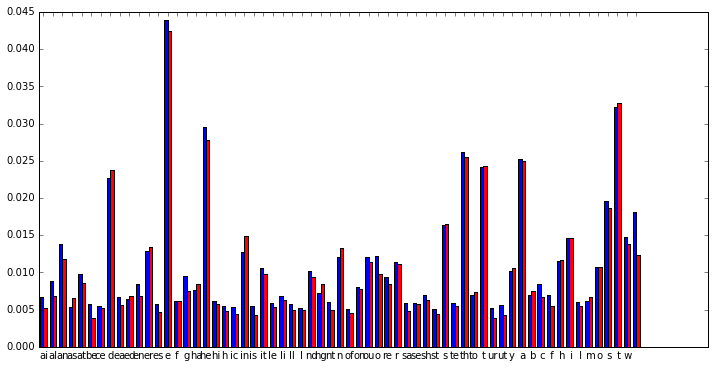

In [15]:
figure(figsize=(12,6))

sig_idx = find(letter_vals2 > 0.005)

b1=bar(arange(len(letter_vals2[sig_idx]))+0.15, letter_vals2[sig_idx], width=0.35, color='b')
b2=bar(arange(len(letter_prob2[sig_idx]))+0.5, letter_prob2[sig_idx], width=0.35, color='r')

ax = gca()

ax.set_xticks(arange(len(letter_vals2[sig_idx]))+0.5)

pair_labels = []
for i in sig_idx:
    pair_labels.append(letter_pairs[i])
    
t1 = ax.set_xticklabels(pair_labels)

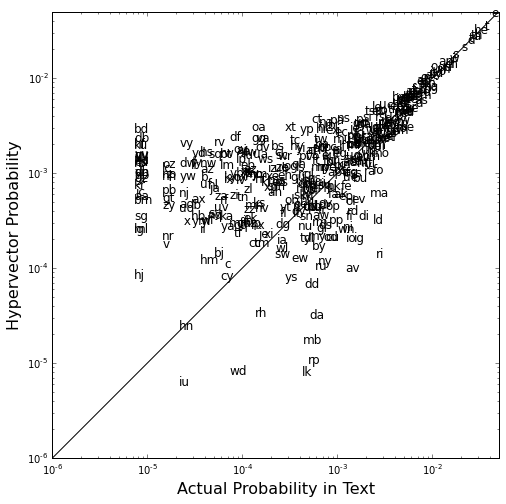

In [16]:
figure(figsize=(8,8))
cla()
plot([1e-7, 0.2], [1e-7, 0.2], 'k')

for i,ll in enumerate(letter_pairs):
    if letter_prob2[i] < 1e-7:
        continue
        
    text(letter_prob2[i], abs(letter_vals2[i]), ll, fontsize=12) # abs to deal with potential negatives
    
ax = gca()
ax.set_xlim([1e-6, 0.05])
ax.set_xscale('log')
ax.set_ylim([1e-6, 0.05])
ax.set_yscale('log')

xlabel('Actual Probability in Text', fontsize=16)
ylabel('Hypervector Probability', fontsize=16)


In [17]:
ngram = 2
ngram_vector = np.ones(N)
alice_vector_log2 = np.zeros(N)

for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)

    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    ngram_val = np.dot(ngram_vector, alice_vector_log2.T) / N
    alice_vector_log2 += 1.0 / (np.exp(ngram_val)) * ngram_vector
    
    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])

    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))
    

In [18]:
letter_vals_log2 = np.zeros(len(random_idx.alphabet)**2)
letter_counts2 = np.zeros(len(random_idx.alphabet)**2)
letter_pairs = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        
        letter_pairs.append(letter1+letter2)
        
        letter_counts2[c] = alice_text.count(letter_pairs[c])
        
        vector = np.roll(letter_vectors[i,:], 1) * letter_vectors[j,:]
        
        letter_vals_log2[c] = np.dot(vector, alice_vector_log2.T) / N
        c+=1

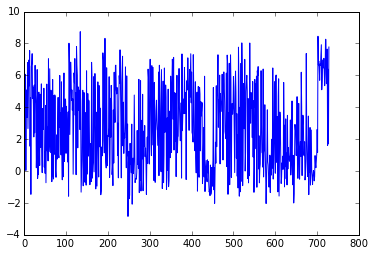

In [19]:
plot(letter_vals_log2)

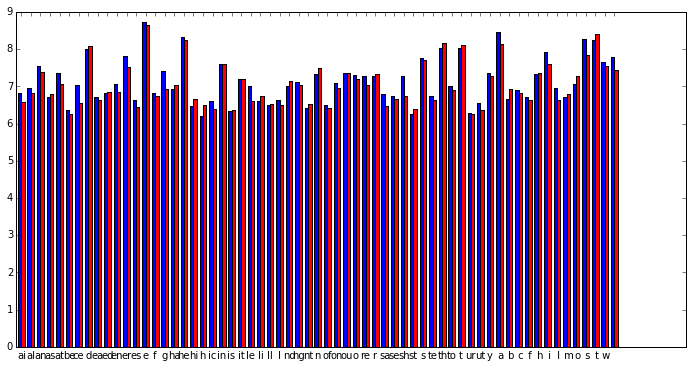

In [20]:
figure(figsize=(12,6))

sig_idx = find(letter_vals2 > 0.005)

b1=bar(arange(len(letter_vals_log2[sig_idx]))+0.15, letter_vals_log2[sig_idx], width=0.35, color='b')
b2=bar(arange(len(letter_counts2[sig_idx]))+0.5, np.log(letter_counts2[sig_idx]), width=0.35, color='r')

ax = gca()

ax.set_xticks(arange(len(letter_vals2[sig_idx]))+0.5)

pair_labels = []
for i in sig_idx:
    pair_labels.append(letter_pairs[i])
    
t1 = ax.set_xticklabels(pair_labels)

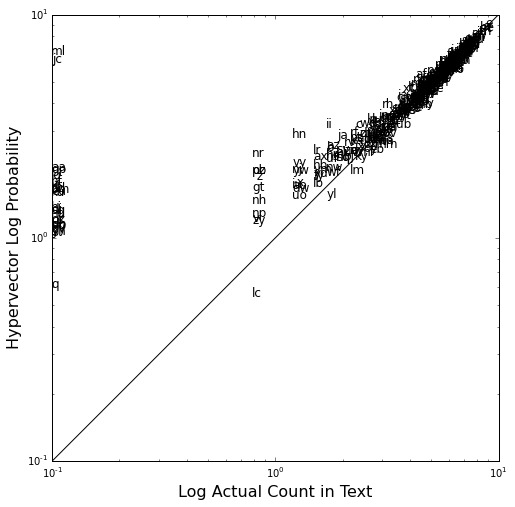

In [21]:
figure(figsize=(8,8))
cla()
plot([0.1, 10], [0.1, 10], 'k')

for i,ll in enumerate(letter_pairs):
    if letter_counts2[i] < 1:
        continue
        
    text(np.log(letter_counts2[i])+1e-1, abs(letter_vals_log2[i])+1e-1, ll, fontsize=12) # abs to deal with potential negatives
    
ax = gca()
#ax.set_xlim([1e-1, 1e1])
ax.set_xscale('log')
#ax.set_ylim([1e-1, 1e1])
ax.set_yscale('log')

xlabel('Log Actual Count in Text', fontsize=16)
ylabel('Hypervector Log Probability', fontsize=16)

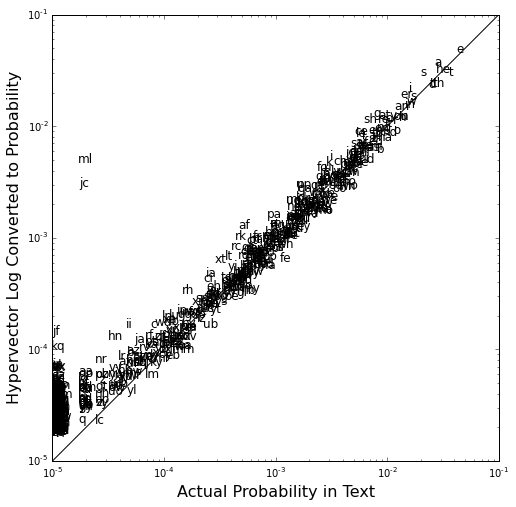

In [22]:
figure(figsize=(8,8))
cla()
plot([1e-5, 1e-1], [1e-5, 1e-1], 'k')

for i,ll in enumerate(letter_pairs):        
    text(letter_counts2[i]/len(alice_text)+1e-5, np.exp(abs(letter_vals_log2[i]))/len(alice_text)+1e-5, ll, fontsize=12) # abs to deal with potential negatives
    
ax = gca()
ax.set_xlim([1e-5, 1e-1])
ax.set_xscale('log')
ax.set_ylim([1e-5, 1e-1])
ax.set_yscale('log')

xlabel('Actual Probability in Text', fontsize=16)
ylabel('Hypervector Log Converted to Probability', fontsize=16)

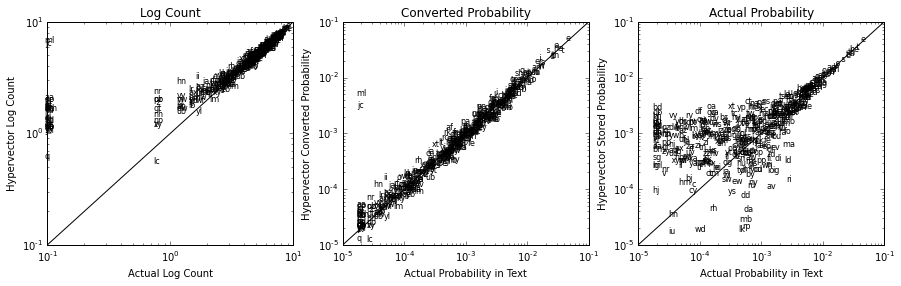

In [23]:
figure(figsize=(15,4))
cla()
subplot(131)
plot([1e-1, 1e1], [1e-1, 1e1], 'k')
subplot(132)
plot([1e-5, 2e-1], [1e-5, 2e-1], 'k')
subplot(133)
plot([1e-5, 2e-1], [1e-5, 2e-1], 'k')

for i,ll in enumerate(letter_pairs):
    if letter_counts2[i] < 1:
        continue
    
    subplot(131)
    text(np.log(letter_counts2[i]+1e-1), abs(letter_vals_log2[i])+1e-1, ll, fontsize=8)
    #plot(np.log(letter_counts3[i]+1e-5), abs(letter_vals_log3[i])+1e-5, '.r')
    subplot(132)
    text(letter_counts2[i]/len(alice_text)+1e-5, np.exp(abs(letter_vals_log2[i]))/len(alice_text), ll, fontsize=8)
    subplot(133)
    text(letter_counts2[i]/len(alice_text)+1e-5, abs(letter_vals2[i])+1e-5, ll, fontsize=8) # abs to deal with potential negatives

ax = subplot(131)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-1, 1e1])
ax.set_ylim([1e-1, 1e1])
title('Log Count')
xlabel('Actual Log Count')
ylabel('Hypervector Log Count')

ax2 = subplot(132)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-5, 1e-1])
ax2.set_ylim([1e-5, 1e-1])
title('Converted Probability')
xlabel('Actual Probability in Text')
ylabel('Hypervector Converted Probability')

ax3 = subplot(133)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-5, 1e-1])
ax3.set_ylim([1e-5, 1e-1])
title('Actual Probability')
xlabel('Actual Probability in Text')
ylabel('Hypervector Stored Probability')


In [24]:
ngram = 3
ngram_vector = np.ones(N)
alice_vector3 = np.zeros(N)
alice_vector_log3 = np.zeros(N)

for i in range(ngram-1):
    lidx = random_idx.alphabet.find(alice_text[i])
    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]

for i,l in enumerate(alice_text[(ngram-1):]):
    lidx = random_idx.alphabet.find(l)

    ngram_vector = np.roll(ngram_vector, 1) * letter_vectors[lidx, :]
    
    alice_vector3 += ngram_vector
    
    ngram_val = np.dot(ngram_vector, alice_vector_log3.T) / N
    alice_vector_log3 += 1.0 / (np.exp(abs(ngram_val))) * ngram_vector
    
    # remove the first letter of the ngram
    fidx = random_idx.alphabet.find(alice_text[i])

    ngram_vector = ngram_vector * np.roll(letter_vectors[fidx, :], (ngram-1))
   

In [25]:
letter_vals_log3 = np.zeros(len(random_idx.alphabet)**3)
letter_vals3 = np.zeros(len(random_idx.alphabet)**3)
letter_counts3 = np.zeros(len(random_idx.alphabet)**3)

letter_trigrams = []
c = 0

for i, letter1 in enumerate(random_idx.alphabet):
    for j, letter2 in enumerate(random_idx.alphabet):
        for k, letter3 in enumerate(random_idx.alphabet):
            
            letter_trigrams.append(letter1+letter2+letter3)
        
            letter_counts3[c] = alice_text.count(letter_trigrams[c])
        
            vector = np.roll(letter_vectors[i,:], 2) * np.roll(letter_vectors[j,:], 1) * letter_vectors[k,:]
            
            letter_vals3[c] = np.dot(vector, alice_vector3.T) / N
            letter_vals_log3[c] = np.dot(vector, alice_vector_log3.T) / N
            c+=1

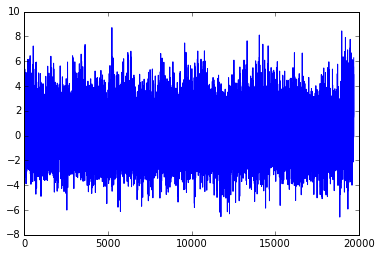

In [26]:
plot(letter_vals_log3)

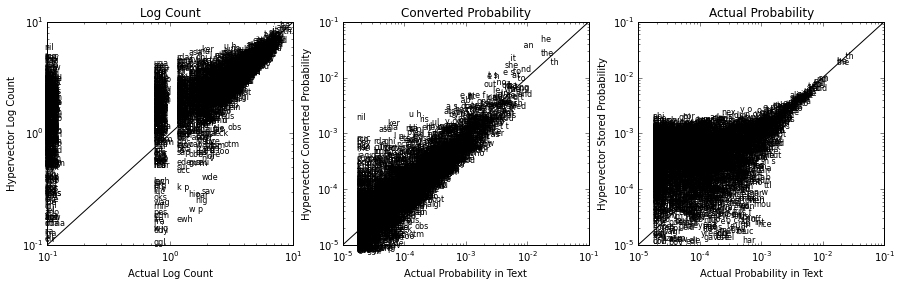

In [27]:
figure(figsize=(15,4))
cla()
subplot(131)
plot([1e-1, 1e1], [1e-1, 1e1], 'k')
subplot(132)
plot([1e-5, 1e-1], [1e-5, 1e-1], 'k')
subplot(133)
plot([1e-5, 1e-1], [1e-5, 1e-1], 'k')

for i,ll in enumerate(letter_trigrams):
    if letter_counts3[i] < 1:
        continue
    
    subplot(131)
    text(np.log(letter_counts3[i]+1e-1), abs(letter_vals_log3[i])+1e-1, ll, fontsize=8)
    #plot(np.log(letter_counts3[i]+1e-5), abs(letter_vals_log3[i])+1e-5, '.r')
    subplot(132)
    text(letter_counts3[i]/len(alice_text)+1e-5, np.exp(abs(letter_vals_log3[i]))/len(alice_text), ll, fontsize=8)
    subplot(133)
    text(letter_counts3[i]/len(alice_text)+1e-5, abs(letter_vals3[i])/len(alice_text)+1e-5, ll, fontsize=8) # abs to deal with potential negatives

ax = subplot(131)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-1, 1e1])
ax.set_ylim([1e-1, 1e1])
title('Log Count')
xlabel('Actual Log Count')
ylabel('Hypervector Log Count')

ax2 = subplot(132)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-5, 1e-1])
ax2.set_ylim([1e-5, 1e-1])
title('Converted Probability')
xlabel('Actual Probability in Text')
ylabel('Hypervector Converted Probability')

ax3 = subplot(133)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim([1e-5, 1e-1])
ax3.set_ylim([1e-5, 1e-1])
title('Actual Probability')
xlabel('Actual Probability in Text')
ylabel('Hypervector Stored Probability')


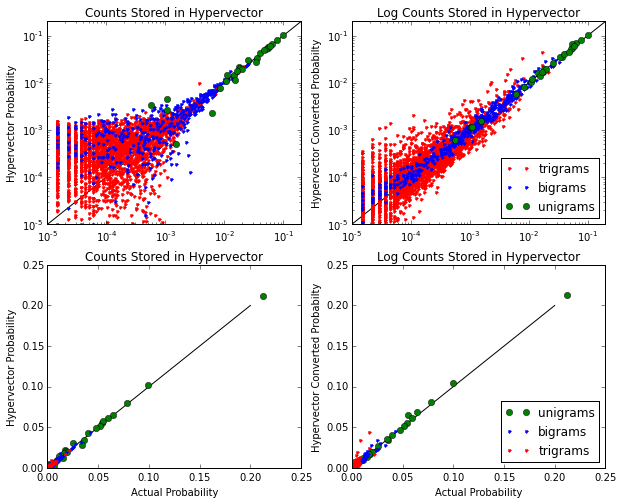

In [28]:
figure(figsize=(10,8))

ax1 = subplot(221)
plot([1e-5,2e-1], [1e-5, 2e-1], 'k')

plot(letter_counts3/len(alice_text), abs(letter_vals3)/len(alice_text), '.r')
plot(letter_counts2/len(alice_text), abs(letter_vals2), '.b')
plot(letter_counts/len(alice_text), abs(hyp_prob1), 'og')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1e-5, 2e-1])
ax1.set_ylim([1e-5, 2e-1])
title('Counts Stored in Hypervector')
ylabel('Hypervector Probability')

ax2 = subplot(222)
plot([1e-5, 2e-1], [1e-5, 2e-1], 'k')

plot(letter_counts3/len(alice_text), np.exp(abs(letter_vals_log3))/len(alice_text), '.r', label='trigrams')
plot(letter_counts2/len(alice_text), np.exp(abs(letter_vals_log2))/len(alice_text), '.b', label='bigrams')
plot(letter_counts/len(alice_text), np.exp(abs(hyp_prob_log))/len(alice_text), 'og', label='unigrams')

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1e-5, 2e-1])
ax2.set_ylim([1e-5, 2e-1])
title('Log Counts Stored in Hypervector')
ylabel('Hypervector Converted Probabilty')
legend(loc='lower right')

ax3 = subplot(223)
plot([1e-5,2e-1], [1e-5, 2e-1], 'k')

plot(letter_counts/len(alice_text), abs(hyp_prob1), 'og')
plot(letter_counts2/len(alice_text), abs(letter_vals2), '.b')
plot(letter_counts3/len(alice_text), abs(letter_vals3)/len(alice_text), '.r')

title('Counts Stored in Hypervector')
xlabel('Actual Probability')
ylabel('Hypervector Probability')

ax4= subplot(224)
plot([1e-5, 2e-1], [1e-5, 2e-1], 'k')
plot(letter_counts/len(alice_text), np.exp(abs(hyp_prob_log))/len(alice_text), 'og', label='unigrams')
plot(letter_counts2/len(alice_text), np.exp(abs(letter_vals_log2))/len(alice_text), '.b', label='bigrams')
plot(letter_counts3/len(alice_text), np.exp(abs(letter_vals_log3))/len(alice_text), '.r', label='trigrams')

title('Log Counts Stored in Hypervector')
xlabel('Actual Probability')
ylabel('Hypervector Converted Probabilty')
legend(loc='lower right')

In [29]:
trigram_log_error = np.sqrt(np.sum((letter_counts3/len(alice_text) - np.exp(abs(letter_vals_log3))/len(alice_text)) ** 2))

bigram_log_error = np.sqrt(np.sum((letter_counts2/len(alice_text) - np.exp(abs(letter_vals_log2))/len(alice_text)) ** 2))

unigram_log_error = np.sqrt(np.sum((letter_counts/len(alice_text) - np.exp(abs(hyp_prob_log))/len(alice_text)) ** 2))

trigram_error = np.sqrt(np.sum((letter_counts3/len(alice_text) - abs(letter_vals3)/len(alice_text)) **2))
bigram_error = np.sqrt(np.sum((letter_counts2/len(alice_text) - abs(letter_vals2)) **2))
unigram_error = np.sqrt(np.sum((letter_counts/len(alice_text) - abs(hyp_prob1)) **2))

print unigram_error, unigram_log_error
print bigram_error, bigram_log_error
print trigram_error, trigram_log_error

0.0145191759973 0.0129588059909
0.0273373860029 0.0226572916074
0.0763769156927 0.0546456448891


In [30]:
trigram_log_ratio = np.sqrt(np.sum((1 - letter_counts3/len(alice_text) / np.exp(abs(letter_vals_log3))/len(alice_text)) ** 2))

bigram_log_ratio = np.sqrt(np.sum((1 - letter_counts2/len(alice_text) / np.exp(abs(letter_vals_log2))/len(alice_text)) ** 2))

unigram_log_ratio = np.sqrt(np.sum((1 - letter_counts/len(alice_text) / np.exp(abs(hyp_prob_log))/len(alice_text)) ** 2))

trigram_ratio = np.sqrt(np.sum((1 - letter_counts3/len(alice_text) / abs(letter_vals3)/len(alice_text)) **2))
bigram_ratio = np.sqrt(np.sum((1 - letter_counts2/len(alice_text) / abs(letter_vals2)) **2))
unigram_ratio = np.sqrt(np.sum((1 - letter_counts/len(alice_text) / abs(hyp_prob1)) **2))

print unigram_ratio, unigram_log_ratio
print bigram_ratio, bigram_log_ratio
print trigram_ratio, trigram_log_ratio

2.96925805758 5.19615242243
91.3675499983 26.9999999992
140.296115412 140.296115412


## Storing arbitrary sequences of fixed number of tokens

Lets do an experiment and see how many letters we really can store in the hypervector. It will be important to test different dimensionality of the hypervectors and compare how the capacity scales with the dimensionality. But there are also other things to consider:

- the dimensionality of the input
- the sparsity of the input
- input statistics -- structured sentences vs random letters?
- permutation vs random orthogonal vs random

The basic strategy of testing the hypervector I'm considering is to have three read-out units: one that is reads out the last input, another that reads out a fixed input away, and another that reads out the first input always. Then we will just add one letter at a time to the hypervector, and read it out as long as possible.


In [31]:
def test_capacity_independent_roll(N, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(len(random_idx.alphabet))
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(len(random_idx.alphabet))

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

        lli = random_idx.alphabet[int(lidx_last_input[i])]
        liK = random_idx.alphabet[int(lidx_input_K[i])]
        lfi = random_idx.alphabet[int(lidx_first_input[i])]

        #print '%03d:' % i, l, lli, liK, lfi

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [43]:
test_N = [100, 500, 1000, 5000, 10000]
#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-independent_roll-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)


0
Duration:  0.230428934097
Duration:  0.324105024338
Duration:  0.490545988083
Duration:  1.79447817802
Duration:  3.45028495789
1
Duration:  0.163758039474
Duration:  0.314467906952
Duration:  0.496380090714
Duration:  1.83313012123
Duration:  3.43900895119
2
Duration:  0.158982992172
Duration:  0.316473960876
Duration:  0.496690988541
Duration:  1.80261588097
Duration:  3.42143201828
3
Duration:  0.161572933197
Duration:  0.319254159927
Duration:  0.492918968201
Duration:  1.804448843
Duration:  3.42638516426
4
Duration:  0.176326036453
Duration:  0.323041915894
Duration:  0.491915941238
Duration:  2.03068804741
Duration:  3.44828701019
data/hypervector_capacity-independent_roll-N=5-r=5-n160418.npz


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [46]:
h = np.load('data/hypervector_capacity-independent_roll-N=5-r=5-n160418.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']


In [47]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
uN = np.array([100, 500, 1000, 5000, 10000])
K=5

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


(0, 900)

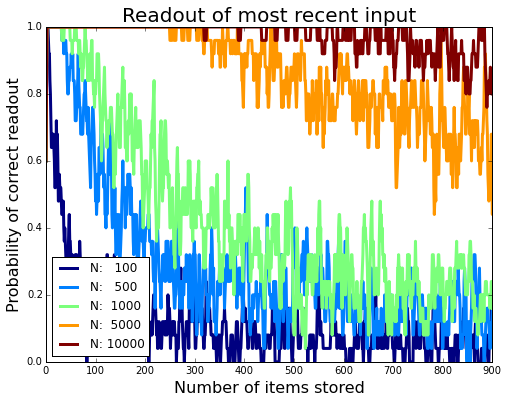

In [48]:
figure(figsize=(8,6))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0, 900])

### Recurrent Neural Networks and Hypervectors

This is a set of experiments testing the capacity of hypervectors with extrapolation to recurrent neural networks. 

This is to answer some of these questions:
1. What is the relationship with capacity and dimensionality of the hypervector?
2. What is the relationship with capacity and dimensionality of the input?
3. Is there any relationship with capacity and input statistics? i.e. natural language vs. random letters
4. What is the difference between permutation, random orthogonal, and random normal weight matrices?


In [49]:
def random_orthogonal(n):
    a = np.random.random((n,n))
    q, r = np.linalg.qr(a)
    
    return q


In [50]:
def test_capacity_natural_ro(N, ro, K=5):
    letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1

    letter_sequence='''this hypervector is going to contain a lot of letters at some point it will run out of capacity and it should 
    no longer be capable of storing patterns indefinitely the dimensionality of the hypervectors will play an important role in its 
    capacity understanding the relationship between dimensionality and capacity is extremely important and wow you can totally put a
    lot more letters in the hypervector than i expected with one thousand dimensions you can easily store one hundred letters in the 
    hypervector with no loss and using a totally random orthogonal matrix this is pretty crazy it seems to be quite noisy for a while 
    but it still retains some information capacity i had to go back and add these letters to push it further and get to the point where 
    it was clearly going haywire the other thing is that the values of the hypervector are also continually increasing'''

    hypercapacity = np.zeros(N)

    # we have ro, but lets also store read out matrices
    last_input = np.linalg.matrix_power(ro, -1)
    input_K = np.linalg.matrix_power(ro, -K)
    first_input = np.linalg.matrix_power(ro, -1) # this one we will build up continuously

    tstart = time.time()
    lidx = np.zeros(len(letter_sequence))
    lidx[0] = random_idx.alphabet.find(letter_sequence[0])
    hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(len(letter_sequence))
    lidx_input_K = np.zeros(len(letter_sequence))
    lidx_first_input = np.zeros(len(letter_sequence))

    for i,l in enumerate(letter_sequence[1:]):
        lidx[i+1] = random_idx.alphabet.find(l)

        hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(last_input, hypercapacity)
        v_input_K = np.dot(input_K, hypercapacity) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(first_input, hypercapacity)
        first_input = np.dot(last_input, first_input) # we have to continually update this readout matrix

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

        lli = random_idx.alphabet[int(lidx_last_input[i])]
        liK = random_idx.alphabet[int(lidx_input_K[i])]
        lfi = random_idx.alphabet[int(lidx_first_input[i])]

        #print '%03d:' % i, l, lli, liK, lfi

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [ ]:
#test_N = [100, 200, 500]
test_N = [100, 500, 1000, 5000, 10000]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_natural_ro(N, random_orthogonal(N))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-natural_ro-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_alll,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N))


In [ ]:
h = np.load('data/hypervector_capacity-independent_roll-N=5-r=5-n160418.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']


In [51]:
h = np.load('data/hypervector_capacity-natural_ro-N=5-r=5-n160315.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
## HACK ##
runs= 5
test_N = [100, 500, 1000, 5000, 10000]

run_id = arange(len(lidx_all))
run_N = array([100, 500, 1000, 5000, 10000] * runs)

print run_N
##

In [53]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
K=5

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


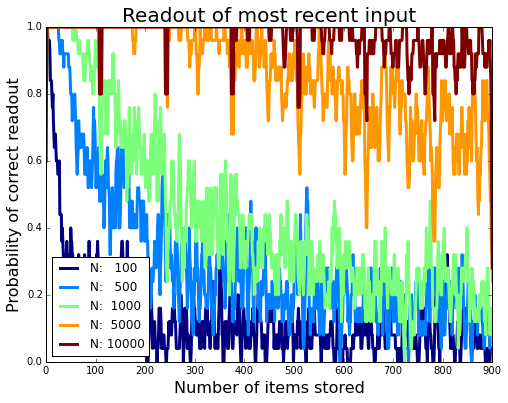

In [54]:
figure(figsize=(8,6))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure xz: Capacity of hyperrnn.** A string of 900 characters was sequentially stored in a hyper-rnn with random orthogonal weights. The readout of the most recent input falls off at different rates depending on the dimensionality. A 1000-D hyper-rnn can store over 50 memories of 27 characters. 

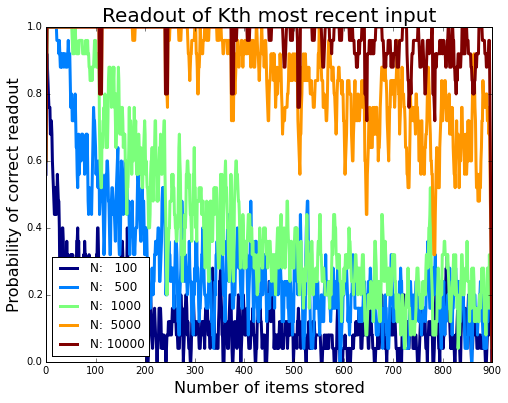

In [55]:
figure(figsize=(8,6))
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

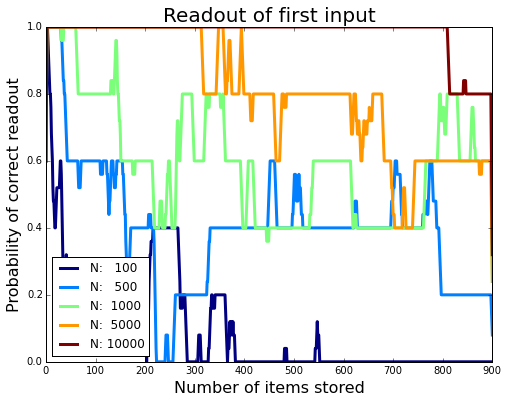

In [56]:
figure(figsize=(8,6))
cm=get_cmap('jet', fi_mean.shape[1])

for i in range(fi_mean.shape[1]):
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of first input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

### Capacity and dimensionality of tokens

Another big factor that could effect the capacity of the hypervector is the dimensionality of the tokens. In the above examples, we have been storing the fixed tokens of 'abcd...xyz '. The hypervector or rnn would receive one of these 27 possibilities at each time point. 

We will call this 27 $D$. 

We can change $D$ by adding more letter tokens. e.g. we could include all lower and upper case letters and have 53 tokens, we could include all punctuation and have even more. 

We can also note a potential relationship between sparsity of the input and $D$. Note that the input is always 1-sparse of $D$, so the input structure is 1-sparse and has a dimensionality of $D$.  We could imagine a different kind of input stream into an RNN, where the input is 2-sparse: i.e. you get two letters simultaneously. However, this can be translated into a 1-sparse representation with $D^2$ number of tokens. This could be used to fundamentally connect an input stream's dimensionality with its sparsity.





In [57]:
def test_capacity_D(N, D, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [62]:
test_N = [1000]
test_D = [2, 4, 8, 16, 32, 64, 128]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_D(N, D)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-D-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D)


0
Duration:  0.241899013519
Duration:  0.257330179214
Duration:  0.334313869476
Duration:  0.386880159378
Duration:  0.586993217468
Duration:  0.861180067062
Duration:  1.50071907043
1
Duration:  0.23557305336
Duration:  0.229912996292
Duration:  0.273239850998
Duration:  0.363924026489
Duration:  0.620668172836
Duration:  0.865138053894
Duration:  1.5034840107
2
Duration:  0.207938909531
Duration:  0.231684923172
Duration:  0.273770093918
Duration:  0.362223148346
Duration:  0.534635066986
Duration:  0.8622610569
Duration:  1.50037503242
3
Duration:  0.207793951035
Duration:  0.230242013931
Duration:  0.27437210083
Duration:  0.364727973938
Duration:  0.538526058197
Duration:  0.861685991287
Duration:  1.50205421448
4
Duration:  0.209141969681
Duration:  0.230947971344
Duration:  0.27266907692
Duration:  0.36394906044
Duration:  0.534918069839
Duration:  0.860667943954
Duration:  1.50086402893
data/hypervector_capacity-D-N=1-D=7-r=5-n160418.npz


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [63]:
h = np.load('data/hypervector_capacity-D-N=1-D=7-r=5-n160418.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']


In [64]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


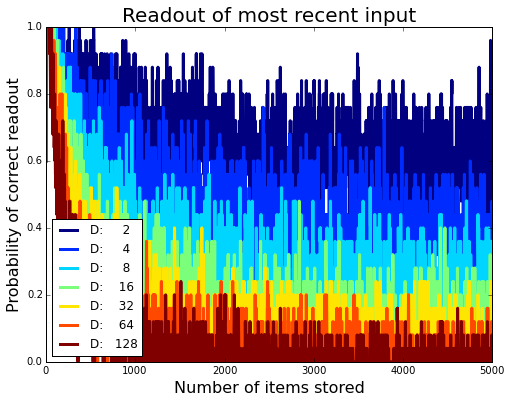

In [65]:
figure(figsize=(8,6))

cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)


(0, 300)

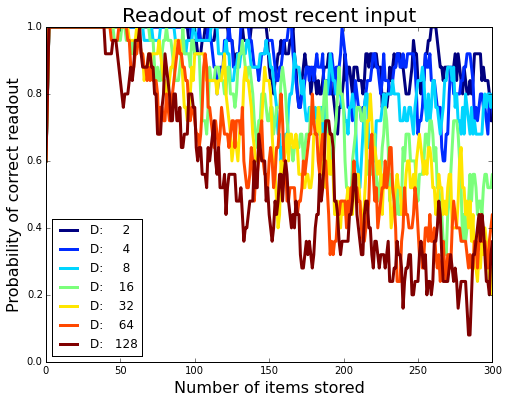

In [66]:
figure(figsize=(8,6))

cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0, 300])

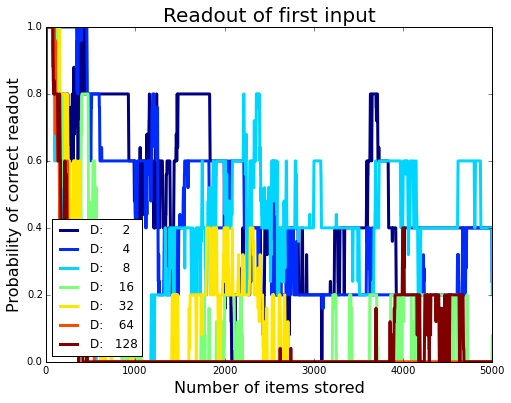

In [67]:
figure(figsize=(8,6))

cm=get_cmap('jet', li_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='lower left');
title('Readout of first input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)


-

According to Plate 1995, the circular convolution can be transformed into a matrix multiply for a fixed vector. This takes us towards reconsidering the Plate circular convolution in terms of a recurrent neural network. In fact, Plate even states this idea that circular convolution with a fixed vector can be turned into a matrix multiply and he states that this could be part of a feed-forward neural network. 

> "The convolution operation can be expressed as a matrix-vector multiplication.
$$
    a \oplus b = M_a b
$$
> "where $M_a$ is the matrix corresponding to convolution by $a$. It has elements $m_{a_{ij}}=a_{i-j}$ (where the subscripts on a are interpreted modulo n). Such matrices are known as "circulant matrices" [6]. The eigenvalues of $M_a$ are the individual (complex valued) elements of the Fourier transform of $a$. The corresponding eigenvectors are the inverse transform of the frequency components (i.e., $(1,0,0,...), (0,1,0,...), etc.$ in the frequency domain). Thus it is possible for the mapping computed by the connections between two layers in a feed-forward network (i.e. a matrix multiplication) to correspond to convolution by a fixed vector."

This should mean that the roll vector can be transformed into a weight matrix. And luckily scipy has a built-in function for making the circulant matrix from a given vector.

In [ ]:
import scipy

roll_vector = 

roll_matrix = scipy.linalg.circulant(roll_vector)